In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1) Data

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = dict(zip(stoi.values(), stoi.keys()))
vocab_size = len(stoi)

In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# 2) Problem 1 - Initial logits are too high

In [5]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden),                     generator=g)
W2 = torch.randn((n_hidden, vocab_size),         generator=g)
b2 = torch.randn((vocab_size),                   generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [6]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h = torch.tanh(emb_cat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

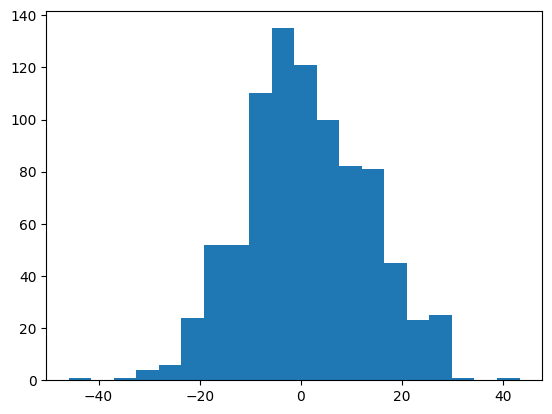

In [7]:
plt.hist(logits.view(-1).tolist(), bins=20);

In [8]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden),                     generator=g)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(0.01)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [9]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h = torch.tanh(emb_cat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

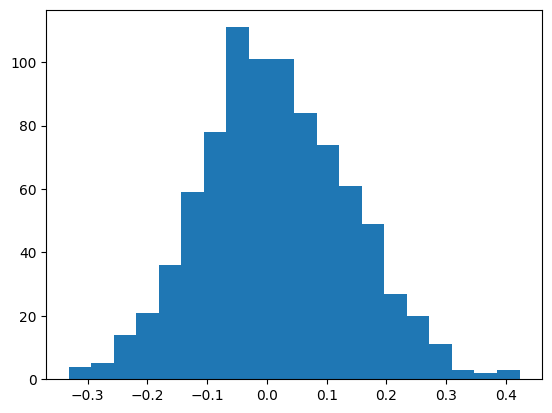

In [10]:
plt.hist(logits.view(-1).tolist(), bins=20);

# 3) Problem 2 - Tanh is being saturated 

In [11]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden),                     generator=g)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(0.01)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [12]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

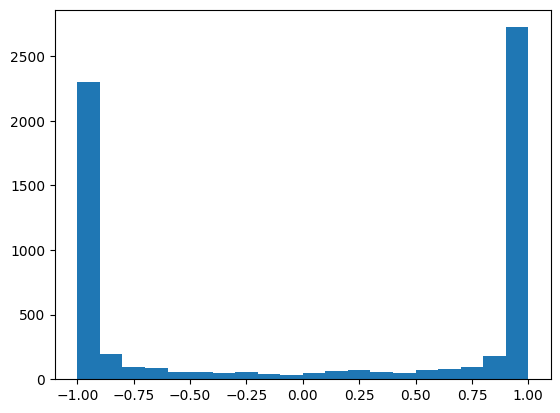

In [13]:
plt.hist(h.view(-1).tolist(), bins=20);

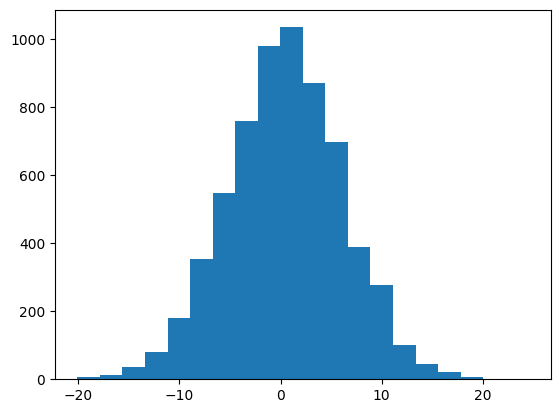

In [14]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

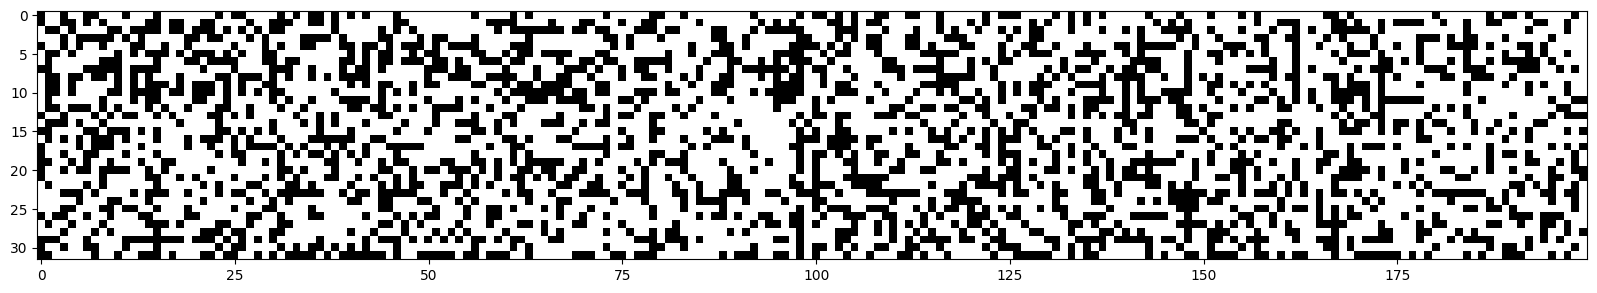

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [16]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(0.2)
b1 = torch.randn((n_hidden),                     generator=g).__mul__(0.01)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(0.01)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [17]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

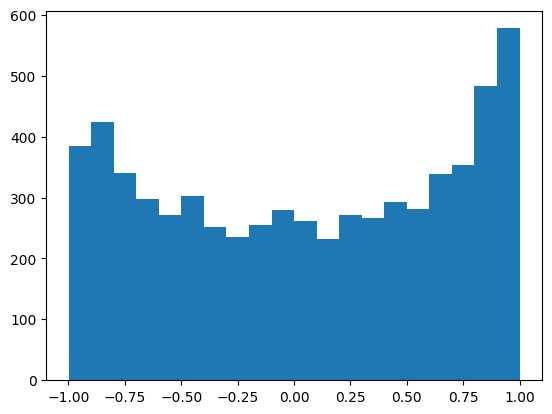

In [18]:
plt.hist(h.view(-1).tolist(), bins=20);

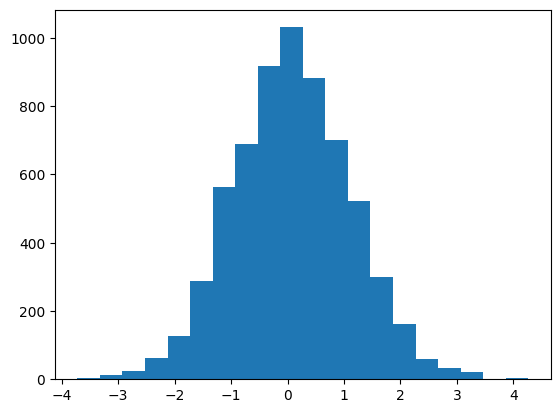

In [19]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

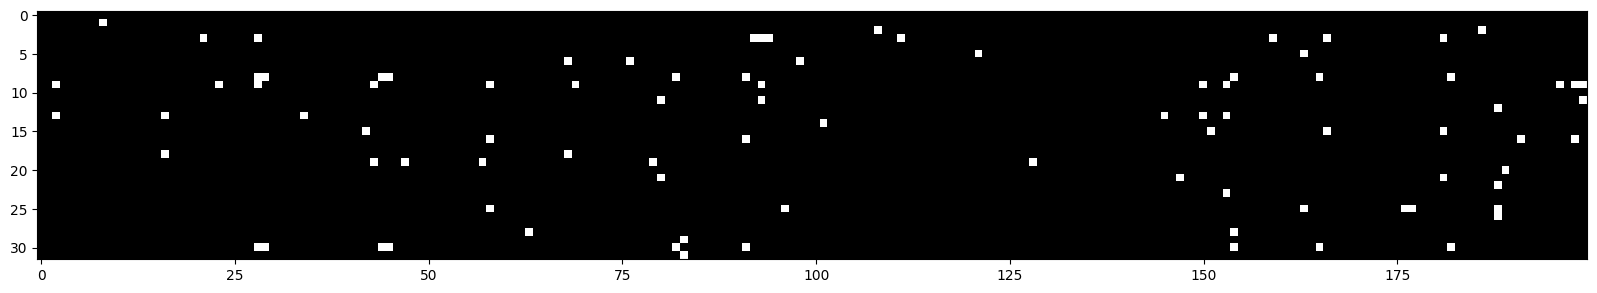

In [20]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

# 4) Kaiming initialization

tensor(-0.0040) tensor(0.9904)
tensor(-0.0020) tensor(3.1590)


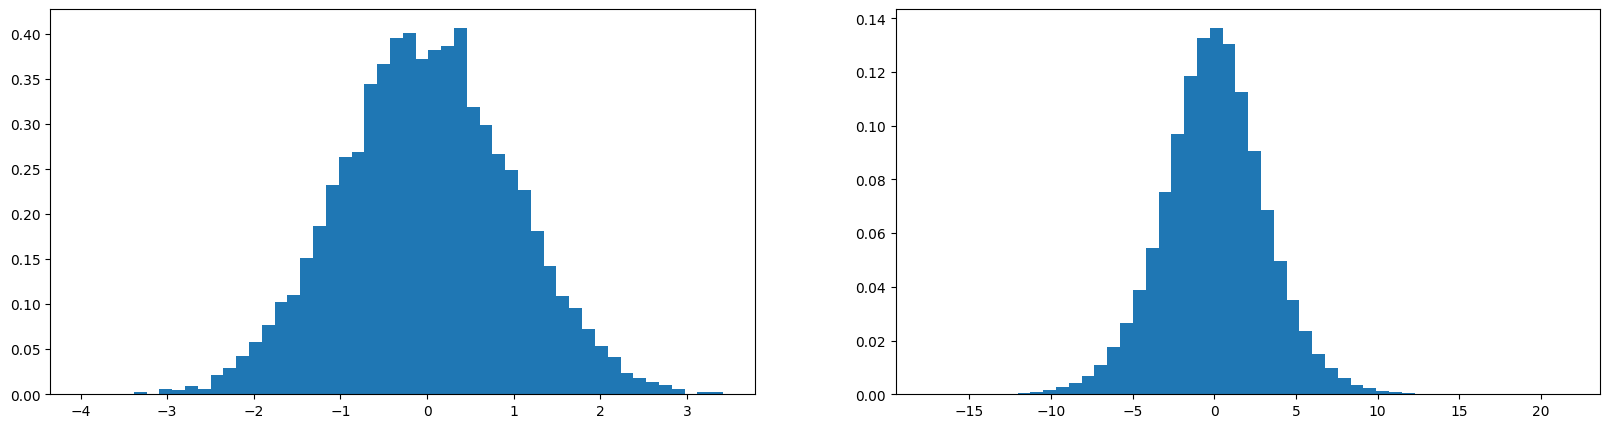

In [21]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0064) tensor(0.9985)
tensor(0.0030) tensor(0.9965)


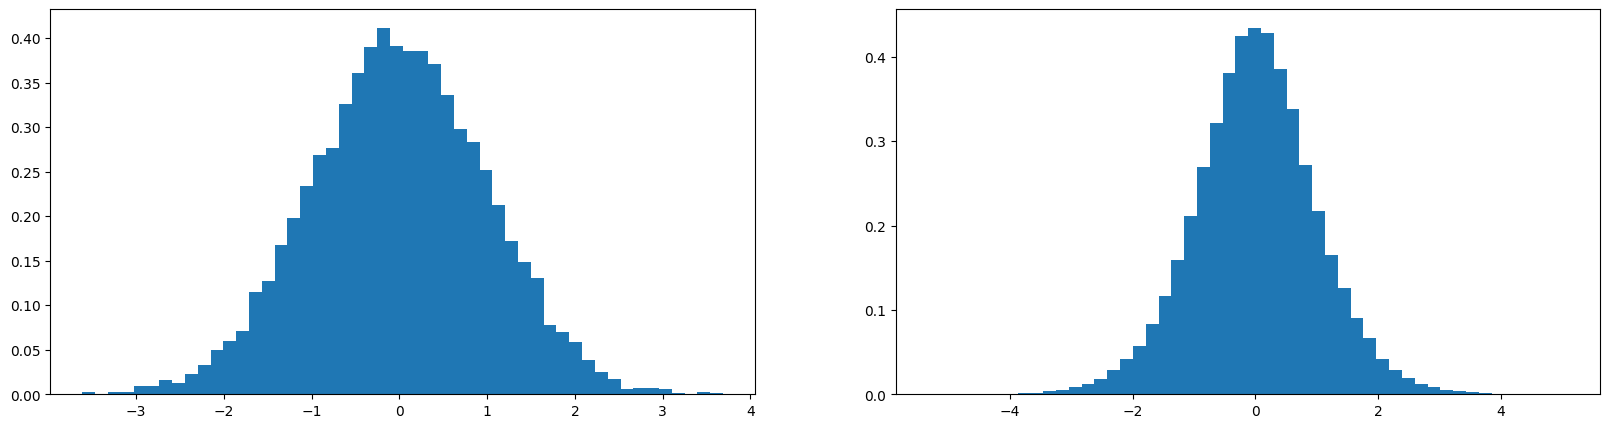

In [22]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# 5) Batch normalization

In [23]:
n_embed = 10
n_hidden = 200

gain_W1 = (5/3) / (n_embed*block_size)**0.5
gain_W2 = (5/3) / (n_hidden)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(gain_W1)
b1 = torch.randn((n_hidden),                     generator=g).__mul__(0.0)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(gain_W2)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [24]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

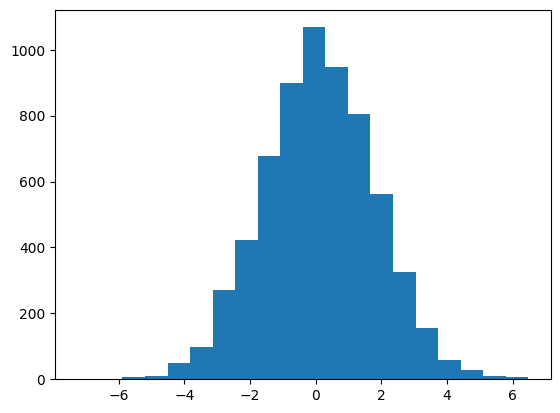

In [25]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

In [26]:
n_embed = 10
n_hidden = 200

gain_W1 = (5/3) / (n_embed*block_size)**0.5
gain_W2 = (5/3) / (n_hidden)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(gain_W1)
b1 = torch.randn((n_hidden),                     generator=g).__mul__(0.0)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(gain_W2)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [27]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h_pre = bngain*(h_pre - h_pre.mean(0, keepdim=True)) / h_pre.std(0, keepdim=True) + bnbias
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

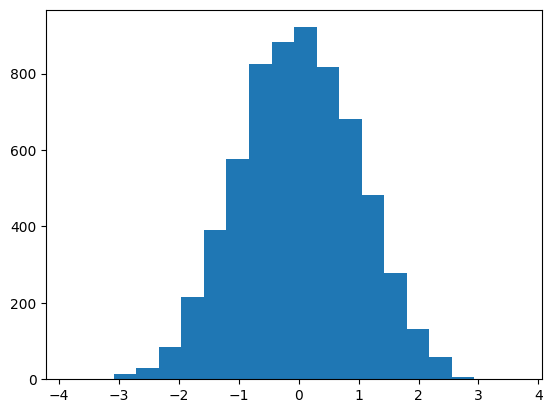

In [28]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

# 6) Training using these tricks

In [29]:
n_embed = 10
n_hidden = 200

gain_W1 = (5/3) / (n_embed*block_size)**0.5
gain_W2 = (5/3) / (n_hidden)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(gain_W1)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(gain_W2)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

      0 / 200000: 3.7930
   1000 / 200000: 2.6276
   2000 / 200000: 2.4839
   3000 / 200000: 2.7072
   4000 / 200000: 2.2574
   5000 / 200000: 2.4481
   6000 / 200000: 2.2813
   7000 / 200000: 2.4065
   8000 / 200000: 2.3330
   9000 / 200000: 2.2961
  10000 / 200000: 2.2078
  11000 / 200000: 2.2123
  12000 / 200000: 2.4319
  13000 / 200000: 2.4506
  14000 / 200000: 2.1661
  15000 / 200000: 2.1102
  16000 / 200000: 2.3413
  17000 / 200000: 2.3657
  18000 / 200000: 2.2584
  19000 / 200000: 2.5296
  20000 / 200000: 2.4482
  21000 / 200000: 2.4081
  22000 / 200000: 2.1145
  23000 / 200000: 2.1428
  24000 / 200000: 2.2708
  25000 / 200000: 2.2292
  26000 / 200000: 2.6966
  27000 / 200000: 2.4279
  28000 / 200000: 1.9757
  29000 / 200000: 2.6084
  30000 / 200000: 2.4354
  31000 / 200000: 2.0528
  32000 / 200000: 2.0038
  33000 / 200000: 2.2262
  34000 / 200000: 2.1602
  35000 / 200000: 1.9012
  36000 / 200000: 2.2751
  37000 / 200000: 2.2613
  38000 / 200000: 2.3205
  39000 / 200000: 2.3761


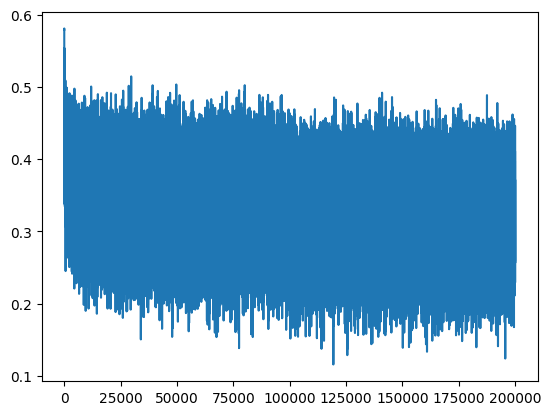

In [30]:
batch_size = 32
max_steps = 200000
stepi = []
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass - linear
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], block_size*n_embed)
    h_pre = emb_cat @ W1
    
    # forward pass - batch norm
    bnmeani = h_pre.mean(0, keepdim=True)
    bnstdi = h_pre.std(0, keepdim=True)
    h_pre = bngain*(h_pre - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    # forward pass - non-linearity
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
plt.plot(stepi, lossi);

In [31]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    h_pre = embcat @ W1
    bnmean = h_pre.mean(0, keepdim=True)
    bnstd = h_pre.std(0, keepdim=True)

In [32]:
@torch.no_grad() 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre = emb_cat @ W1
    h_pre = bngain*(h_pre - bnmean) / bnstd + bnbias
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.071434497833252
val 2.1095268726348877


In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        emb_cat = emb.view(emb.shape[0], -1)
        h_pre = emb_cat @ W1
        h_pre = bngain*(h_pre - bnmean) / bnstd + bnbias
        h = torch.tanh(h_pre)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dex.
mariah.
makima.
kayden.
maimitta.
malkadi.
kata.
kreezyne.
javer.
got.
shik.
jence.
kinzotedo.
kaley.
masidgy.
tiavion.
rosbstihani.
gavon.
lus.
kashra.


# 7) Torch-ify the code

In [34]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [35]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

In [36]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [37]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 0.5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [38]:
batch_size = 32
max_steps = 1000
stepi = []
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0 /   1000: 3.2925


layer 1 (      Tanh): mean -0.02, std 0.46, saturated: 0.00%
layer 3 (      Tanh): mean +0.01, std 0.32, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.29, saturated: 0.00%
layer 7 (      Tanh): mean -0.01, std 0.30, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.37, saturated: 0.00%


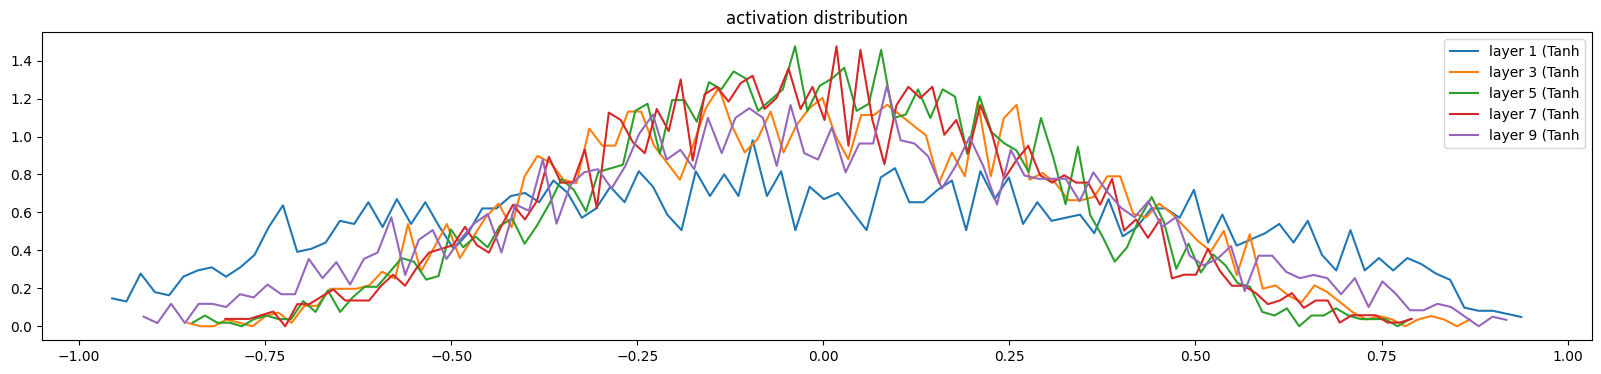

In [39]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


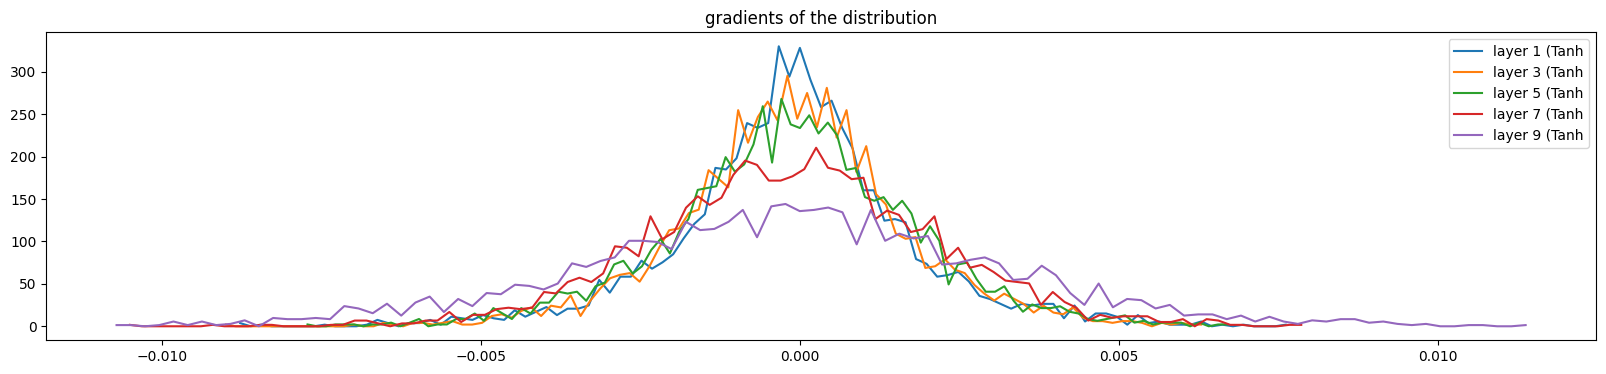

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients of the distribution');

weight   (27, 10) | mean -0.000587 | std 8.864739e-03 | grad:data ratio 8.803638e-03
weight  (30, 100) | mean +0.000209 | std 1.042990e-02 | grad:data ratio 1.017176e-01
weight (100, 100) | mean +0.000058 | std 4.745503e-03 | grad:data ratio 8.771636e-02
weight (100, 100) | mean -0.000057 | std 3.395909e-03 | grad:data ratio 6.309059e-02
weight (100, 100) | mean +0.000037 | std 3.395766e-03 | grad:data ratio 6.315144e-02
weight (100, 100) | mean +0.000029 | std 4.476884e-03 | grad:data ratio 8.140086e-02
weight  (100, 27) | mean -0.000000 | std 1.098610e-02 | grad:data ratio 9.825571e-02


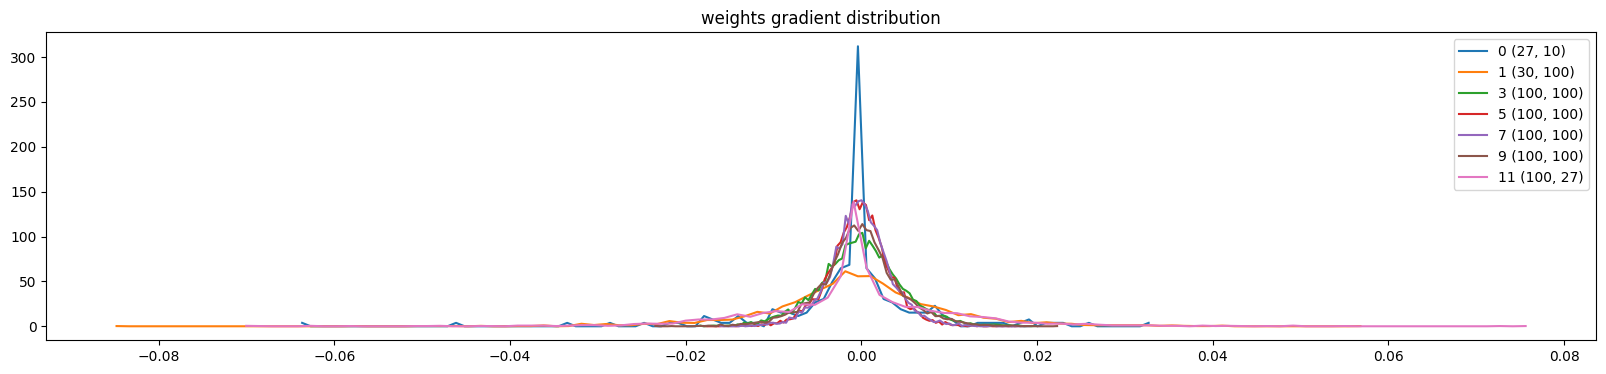

In [41]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

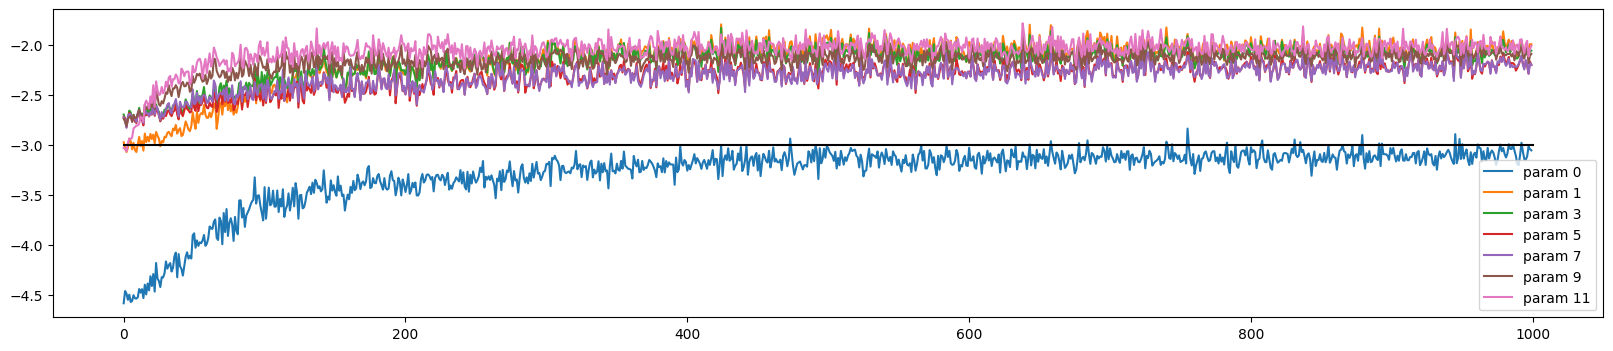

In [42]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

# 8) Adjusting the initial weights (Kaiming)

In [43]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [44]:
batch_size = 32
max_steps = 1000
stepi = []
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0 /   1000: 3.7987


layer 1 (      Tanh): mean -0.03, std 0.76, saturated: 21.19%
layer 3 (      Tanh): mean -0.00, std 0.72, saturated: 12.75%
layer 5 (      Tanh): mean -0.01, std 0.74, saturated: 12.97%
layer 7 (      Tanh): mean -0.02, std 0.75, saturated: 13.94%
layer 9 (      Tanh): mean -0.01, std 0.73, saturated: 13.22%


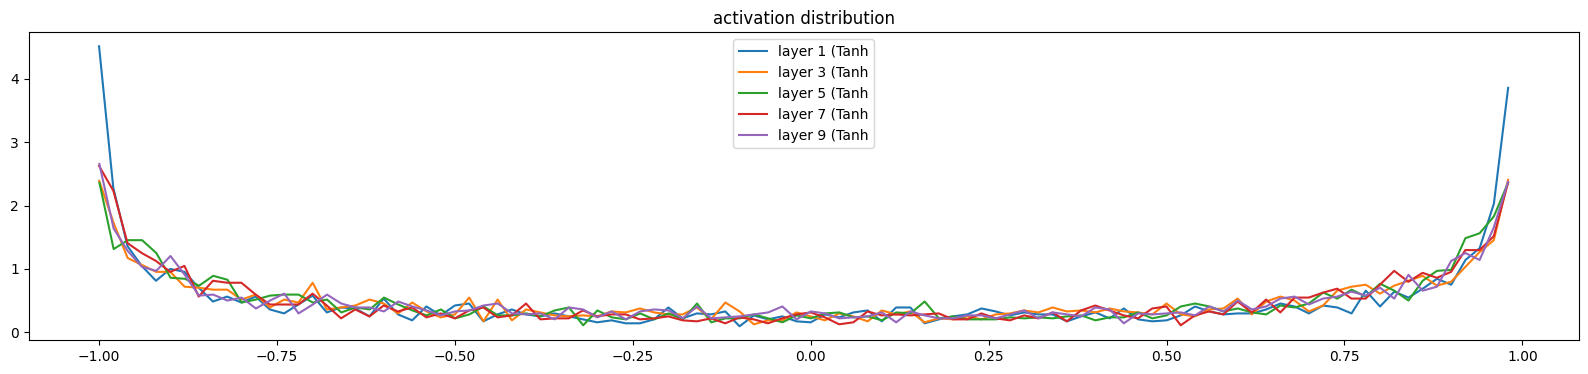

In [45]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


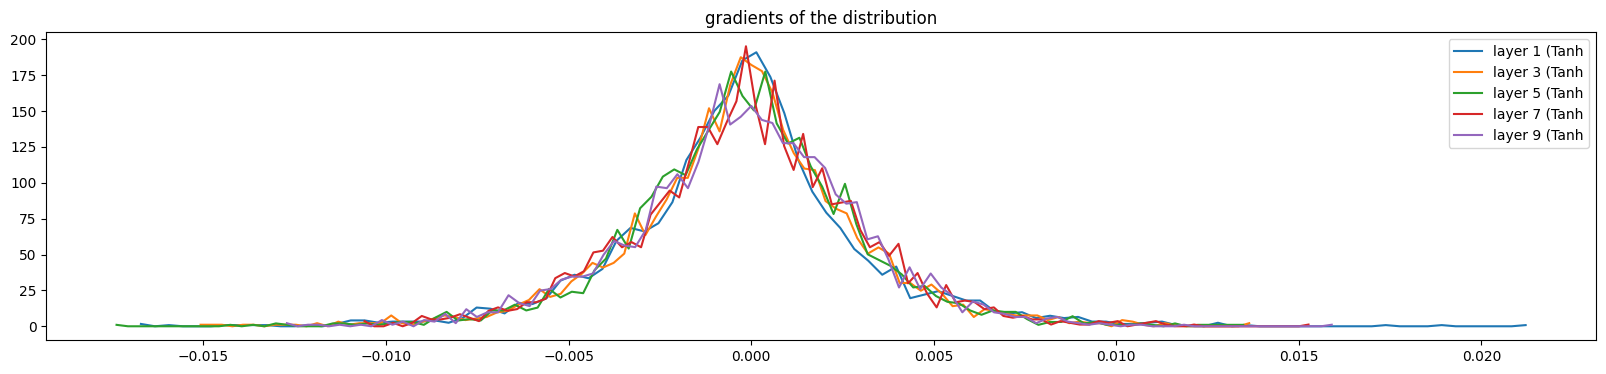

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients of the distribution');

weight   (27, 10) | mean +0.000640 | std 1.048565e-02 | grad:data ratio 1.047727e-02
weight  (30, 100) | mean +0.000012 | std 9.127206e-03 | grad:data ratio 2.912985e-02
weight (100, 100) | mean -0.000016 | std 7.878306e-03 | grad:data ratio 4.676824e-02
weight (100, 100) | mean +0.000070 | std 6.783284e-03 | grad:data ratio 3.996779e-02
weight (100, 100) | mean -0.000044 | std 6.458937e-03 | grad:data ratio 3.828624e-02
weight (100, 100) | mean -0.000016 | std 6.409561e-03 | grad:data ratio 3.814461e-02
weight  (100, 27) | mean -0.000000 | std 2.026468e-02 | grad:data ratio 1.905432e-01


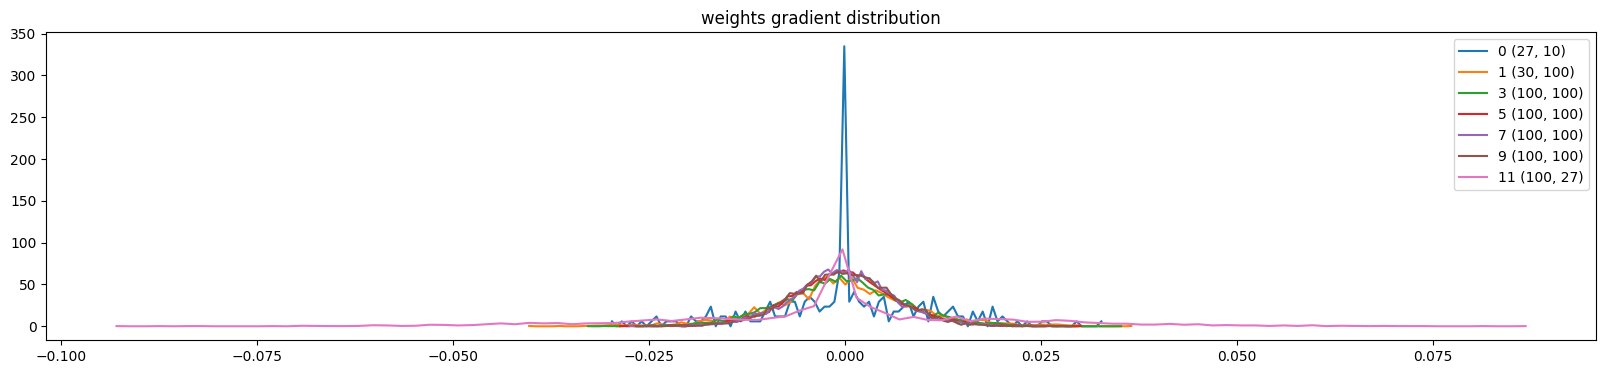

In [47]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

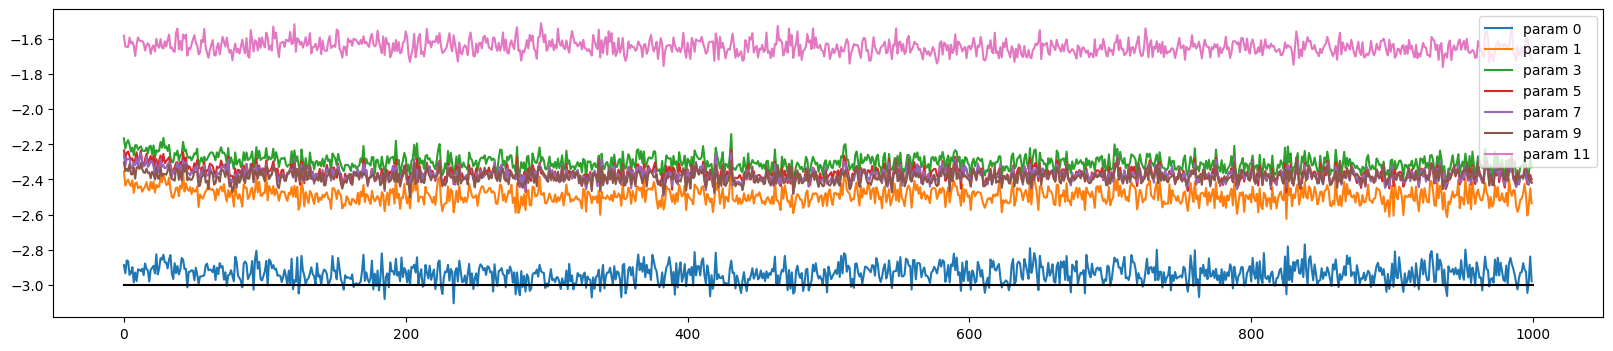

In [48]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

# 9) Using batchnorm

In [49]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [50]:
batch_size = 32
max_steps = 1000
stepi = []
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0 /   1000: 3.3005


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.66%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.28%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.88%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.28%


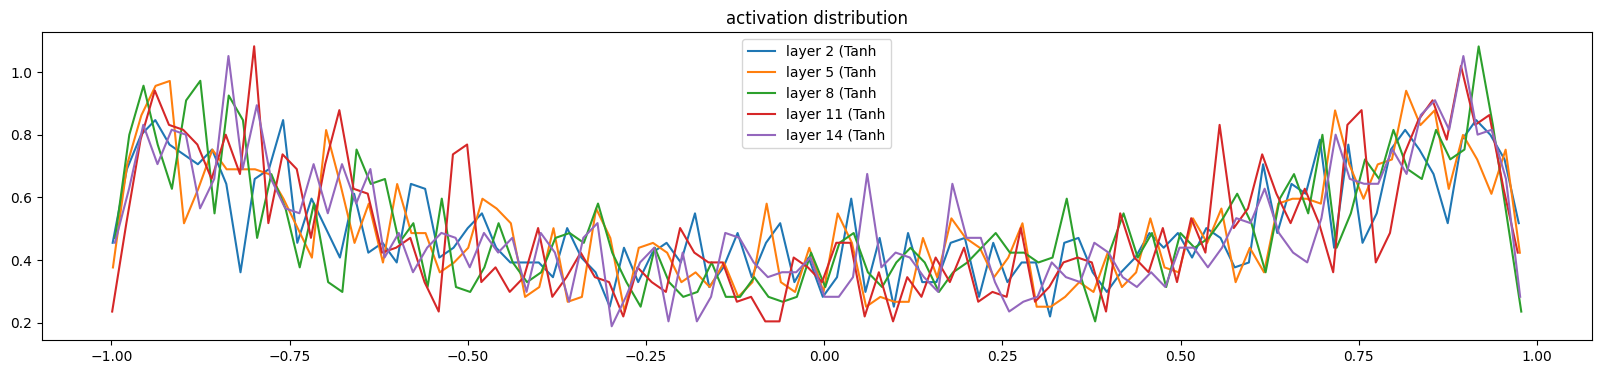

In [51]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


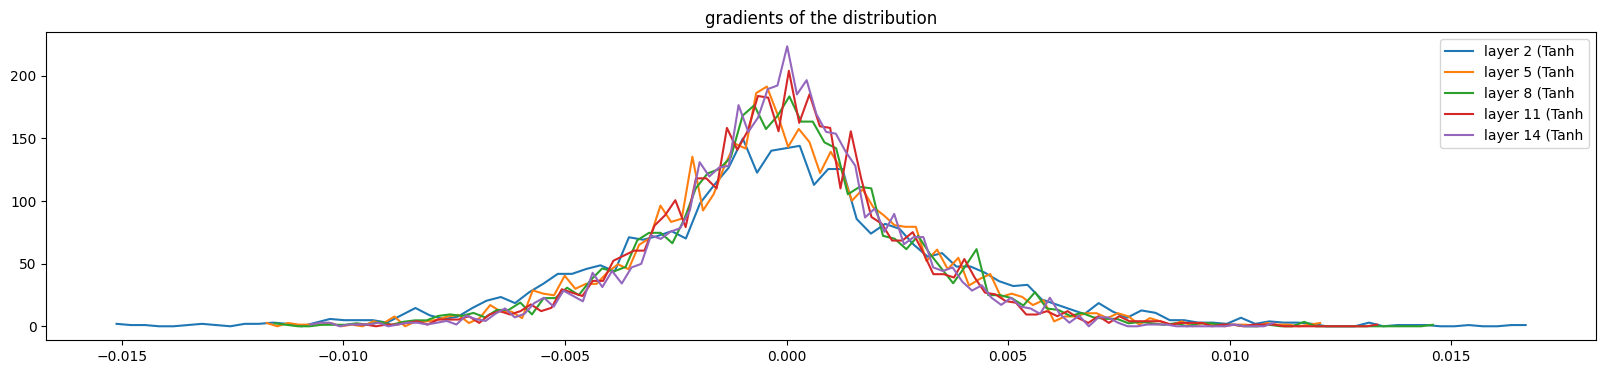

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients of the distribution');

weight   (27, 10) | mean +0.000000 | std 9.647731e-03 | grad:data ratio 9.637836e-03
weight  (30, 100) | mean -0.000166 | std 9.776168e-03 | grad:data ratio 3.127543e-02
weight (100, 100) | mean -0.000209 | std 8.172259e-03 | grad:data ratio 4.888077e-02
weight (100, 100) | mean -0.000038 | std 6.768908e-03 | grad:data ratio 4.013460e-02
weight (100, 100) | mean -0.000050 | std 6.628298e-03 | grad:data ratio 3.949151e-02
weight (100, 100) | mean -0.000015 | std 6.623098e-03 | grad:data ratio 3.944717e-02
weight  (100, 27) | mean +0.000030 | std 1.264065e-02 | grad:data ratio 7.584136e-02


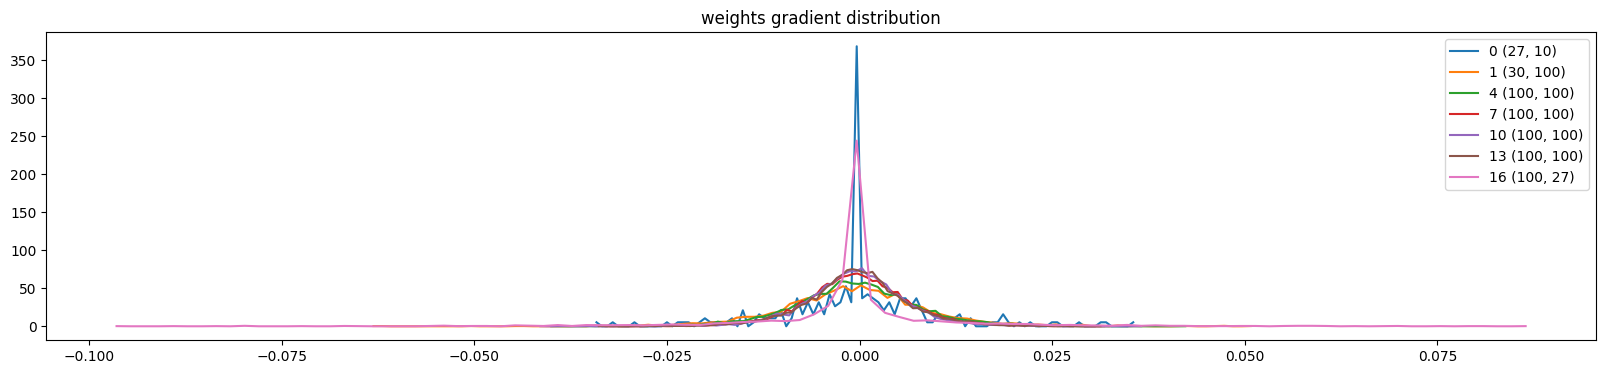

In [53]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

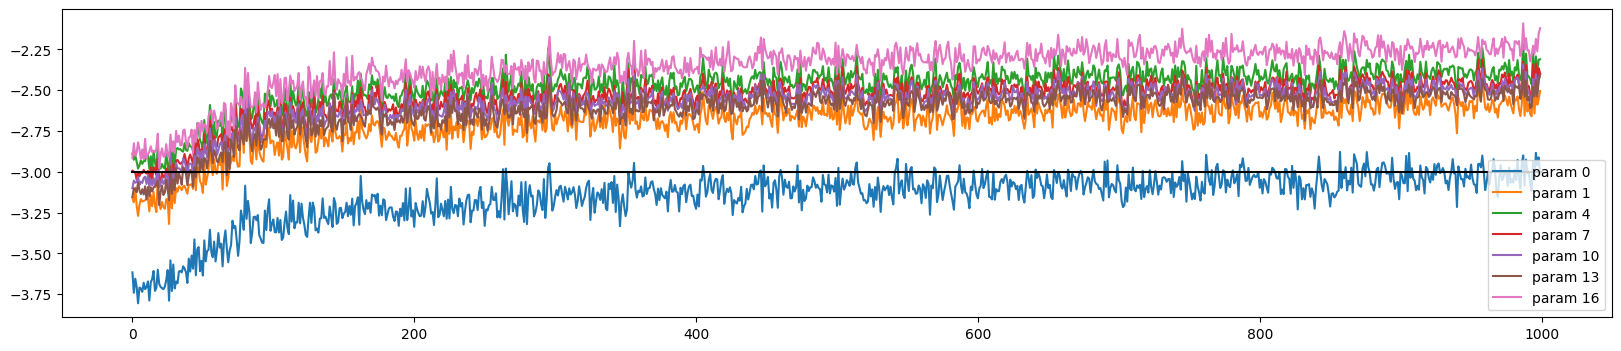

In [54]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);